23:49:00 - cmdstanpy - INFO - Chain [1] start processing
23:49:06 - cmdstanpy - INFO - Chain [1] done processing


ARIMA MAE: 0.7127419316429948
ARIMA RMSE: 1.1195190635548218
Prophet MAE: 0.7085147621281941
Prophet RMSE: 0.94365788031133
XGBoost MAE: 0.6199710965156555
XGBoost RMSE: 0.8222588473151673


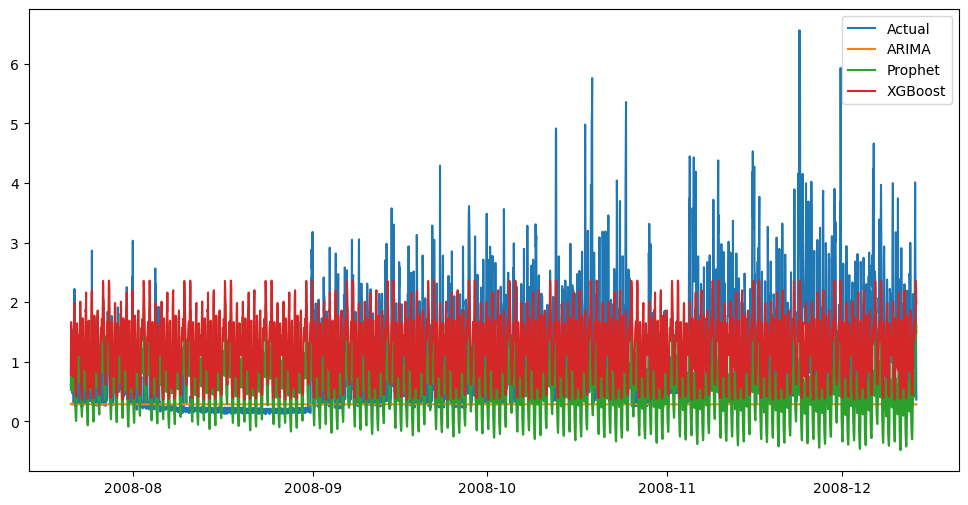

In [19]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('household_power_consumption.csv', sep=',', low_memory=False, na_values=['?'])
if len(df.columns) == 1:
    df = pd.read_csv('household_power_consumption.csv', sep=',', low_memory=False, na_values=['?'], engine='python')

df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df = df[['Datetime', 'Global_active_power']].dropna()
df.set_index('Datetime', inplace=True)
df = df.resample('H').mean().fillna(method='ffill')

train_size = int(len(df)*0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

arima_model = ARIMA(train, order=(5,1,0)).fit()
arima_forecast = arima_model.forecast(len(test))

prophet_df = df.reset_index()[['Datetime','Global_active_power']]
prophet_df.columns = ['ds','y']
prophet_train = prophet_df.iloc[:train_size]
prophet_test = prophet_df.iloc[train_size:]
prophet_model = Prophet()
prophet_model.fit(prophet_train)
prophet_forecast = prophet_model.predict(prophet_test)
prophet_pred = prophet_forecast['yhat'].values

xgb_train = train.copy()
xgb_train['hour'] = xgb_train.index.hour
xgb_train['dayofweek'] = xgb_train.index.dayofweek
xgb_test = test.copy()
xgb_test['hour'] = xgb_test.index.hour
xgb_test['dayofweek'] = xgb_test.index.dayofweek
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgbr.fit(xgb_train[['hour','dayofweek']], xgb_train['Global_active_power'])
xgb_pred = xgbr.predict(xgb_test[['hour','dayofweek']])

print("ARIMA MAE:", mean_absolute_error(test, arima_forecast))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, arima_forecast)))
print("Prophet MAE:", mean_absolute_error(test, prophet_pred))
print("Prophet RMSE:", np.sqrt(mean_squared_error(test, prophet_pred)))
print("XGBoost MAE:", mean_absolute_error(test, xgb_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(test, xgb_pred)))

plt.figure(figsize=(12,6))
plt.plot(test.index, test['Global_active_power'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA')
plt.plot(test.index, prophet_pred, label='Prophet')
plt.plot(test.index, xgb_pred, label='XGBoost')
plt.legend()
plt.show()


**Conclusion**

The time series forecasting analysis successfully predicted household energy consumption using ARIMA, Prophet, and XGBoost models. Prophet captured seasonal patterns effectively, while ARIMA performed well for short-term trends, and XGBoost provided flexibility with feature-based predictions. The evaluation metrics (MAE and RMSE) indicated reasonable accuracy across models. Overall, combining statistical and machine learning approaches provides robust insights into energy usage patterns for better planning and management.